In [1]:
import numpy as np
import matplotlib.pyplot as plt


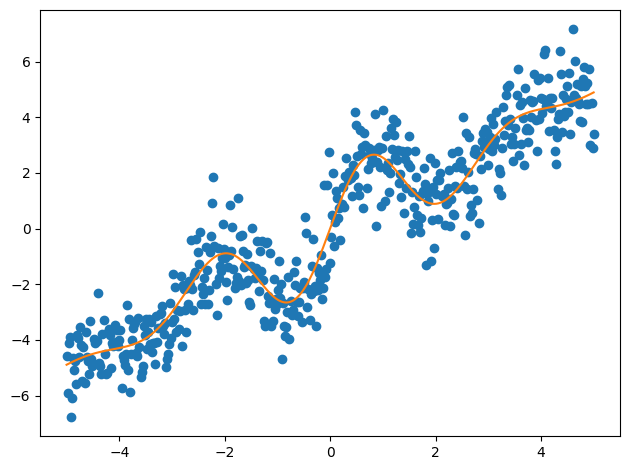

In [2]:
# Let us generate data points from a relatively complicated function
N = 500
alpha, sigma = 2., 3.
X = np.linspace(-5, 5, num=N)
y = X + (alpha * np.sin((2. * np.pi * X) / sigma) * np.exp(-(X ** 2) / (sigma ** 2)))
# Add some random noise
rng = np.random.default_rng(42)
y_noisy = y + rng.standard_normal(N)
# Show the data points
plt.plot(X, y_noisy, 'o')
plt.plot(X, y)
plt.tight_layout()

train shape: (375,)
test shape: (125,)
train y shape: (375,)
test y shape: (125,)


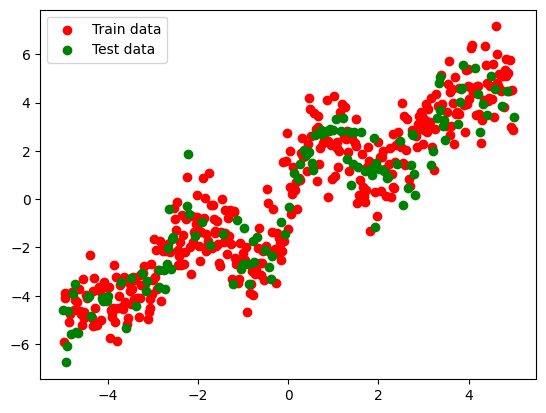

In [3]:
data = np.vstack((X, y))
# Get permuted indices
permuted_indices = rng.permutation(len(X))

# Apply the permutation to both X and y
X_permuted = X[permuted_indices]
y_permuted = y_noisy[permuted_indices]

train_ratio = 0.75
len_data = len(X)
train_size = int(len_data * train_ratio)
X_train = X_permuted[:train_size].flatten()
X_test = X_permuted[train_size:].flatten()
y_train = y_permuted[:train_size].flatten()
y_test = y_permuted[train_size:].flatten()

print(f"train shape: {X_train.shape}")
print(f"test shape: {X_test.shape}")
print(f"train y shape: {y_train.shape}")
print(f"test y shape: {y_test.shape}")

plt.scatter(X_train, y_train, color='red', label='Train data')
plt.scatter(X_test, y_test, color='green', label='Test data')
plt.legend()
plt.show()

GeneticNN(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
tensor(10.2679, grad_fn=<MseLossBackward0>)
tensor(10.2368, grad_fn=<MseLossBackward0>)
tensor(10.2056, grad_fn=<MseLossBackward0>)
tensor(10.1742, grad_fn=<MseLossBackward0>)
tensor(10.1428, grad_fn=<MseLossBackward0>)
tensor(10.1115, grad_fn=<MseLossBackward0>)
tensor(10.0802, grad_fn=<MseLossBackward0>)
tensor(10.0490, grad_fn=<MseLossBackward0>)
tensor(10.0181, grad_fn=<MseLossBackward0>)
tensor(9.9875, grad_fn=<MseLossBackward0>)
tensor(9.9572, grad_fn=<MseLossBackward0>)
tensor(9.9273, grad_fn=<MseLossBackward0>)
tensor(9.8980, grad_fn=<MseLossBackward0>)
tensor(9.8691, grad_fn=<MseLossBackward0>)
tensor(9.8409, grad_fn=<MseLossBackward0>)
tensor(9.8132, grad_fn=<MseLossBackward0>)
tensor(9.7863, grad_fn=<MseLossBackward0>)
tensor(9.7601, grad_fn=<MseLossBackward0>)
tensor(9.7346, grad_fn=<M

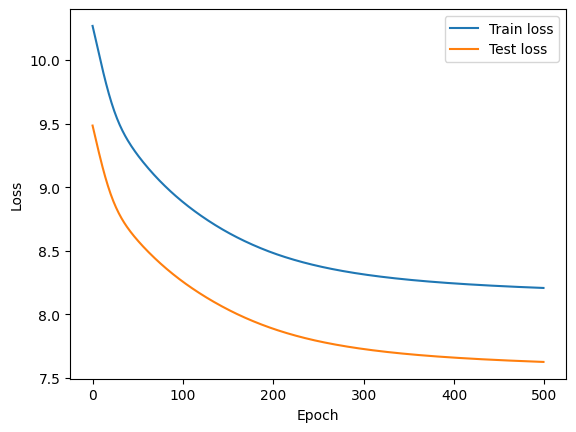

In [4]:
from model import GeneticNN
import torch

DNA = [1, 1, 1]
model = GeneticNN(DNA)
print(model)

criterion = torch.nn.MSELoss() #@param
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #@param
epochs = 500 #@param

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Train the model
train_losses, test_losses = model.train_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, criterion, optimizer, epochs)


print(len(train_losses))
print(len(test_losses))

plt.plot([ i for i in range(epochs) ], train_losses, label='Train loss')
plt.plot([ i for i in range(epochs) ], test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()